<img src="https://www.arm.gov/uploads/ECOR_new_SGP1.jpg" width=800 alt="ARM ECOR Banner"></img>

# Surface Flux Analysis

---

## Overview
The Atmospheric Radiation Measurement (ARM) user facility has a significant data record of surface flux (momentum, sensible and latent heat, and CO2) data available at multiple locations around the Southern Great Plains (SGP) observatory.  This project will explore long-term data analysis of the fluxes and break down the flux statistics by vegetation type.  Students will gain experience with Python, surface flux data, ARM, and open-source software. Topics included in this notebook are:

1. What is the ARM Eddy Correlation Measurement System (ECOR)?
1. Downloading and Reading in ECOR data
1. Quality controlling ECOR data at SGP
1. Crop Type Information
1. Putting it all together!

## Prerequisites
This notebook will rely heavily on Python and the [Atmospheric data Community Toolkit (ACT)](https://github.com/ARM-DOE/ACT).  Don't worry if you don't have experience with either, this notebook will walk you though what you need to know.

You will also need an account and token to download data using the ARM Live webservice.  Navigate to the [webserive information page](https://adc.arm.gov/armlive/) and log in to get your token.  Your account username will be your ARM username.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [ACT](https://github.com/ARM-DOE/ACT) | Helpful | |

- **Time to learn**: 60 Minutes
- **System requirements**:
    - Python 3.11 or latest
    - ACT v1.4.5 or latest
    - numpy
    - xarray
    - matplotlib

---

## Imports

In [2]:
import act
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## What is the ARM Eddy Correlation Measurement System (ECOR)?


The eddy correlation (ECOR) flux measurement system provides half-hour measurements of the surface turbulent fluxes of momentum, sensible heat, latent heat, and carbon dioxide. The ECOR uses the eddy covariance technique, which involves correlation of the vertical wind component with the horizontal wind component, air temperature, water vapor density, and CO2 density.

More information on the system can be found on [ARM's ECOR instrument page](https://arm.gov/capabilities/instruments/ecor).  Please note that the [Instrument Handbook](https://www.arm.gov/publications/tech_reports/handbooks/ecor_handbook.pdf) has a lot of useful information in it as well, including some good quality control information that will come in handy later.

### Why are fluxes important?

Land-atmosphere interactions (LAI) are the main drivers of earth's surface water and energy budgets.  Understanding how energy, heat, and greenhouse gases flow from the surface is important for verifying and improving global climate models.  Understanding the impact crop type has on these fluxes can have wide impacts as 52% of the U.S. land base is used for agriculture ([USDA](https://www.ers.usda.gov/topics/farm-economy/land-use-land-value-tenure/#:~:text=Agricultural%20production%20is%20a%20major,of%20the%20U.S.%20land%20base.)) with the Food and Agriculture Organization of the United Nations indicating that roughly 38% of the entire world is dedicated to agriculture.

## Downloading and Reading in ARM Data
In this section, you will download data from ARM's Live Data Web Service and read it in to an xarray dataset using ACT.  __Warning!  Do not commit your username and token to the Github repo!  You do not want to make these public__

If you read the instrument webpage, it noted that the 30ecor datastream has the uncorrected fluxes and it's recommended that routine ECOR corrections are applied.  The corrected data are available in the 30qcecor Value-Added Product (VAP) so that is what we are going to be working with.  Note that this dataset is only available from 2010 onward and the SGP ECOR systems were upgraded in October 2019 and are producing corrected fluxes in the ECORSF datastream.  While the QCECOR product has corrected fluxes it doees not include wind direction and speed that we will need later on so we will need to download both the QCECOR and base ECOR data products.

### Downloading data

In [193]:
# Set your ARM Live data username and password.
username = 'theisen'
token = '500ad19936dd73a0'

# Set the datastream and dates for download.  Let's just look at one week to start
# If you don't know the datastream you can always download through data discovery as well
# https://adc.arm.gov/discovery/#/
# You can also easily change the facility (E14) to other ones as well
datastream = 'sgp30qcecorE14.s1'
startdate = '20180501'
enddate = '20180530'

# Download data using the webservice
qcecor_files = act.discovery.download_data(username, token, datastream, startdate, enddate)

# Download ECOR data using the webservice
datastream = 'sgp30ecorE14.b1'
ecor_files = act.discovery.download_data(username, token, datastream, startdate, enddate)

[DOWNLOADING] sgp30qcecorE14.s1.20180501.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180502.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180503.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180504.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180505.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180506.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180507.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180508.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180509.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180510.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180511.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180512.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180513.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180514.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180515.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180516.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180517.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180518.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1.20180519.000000.nc
[DOWNLOADING] sgp30qcecorE14.s1

### Reading in data

In [194]:
# Reading in data to an xarray dataset is very easy using ACT
# ARM has some standards that can cause issues with the xarray reader at times
ds = act.io.armfiles.read_netcdf(qcecor_files)
ds_ecor = act.io.armfiles.read_netcdf(ecor_files)

# Add the wind speed and dir to the main object
ds['wind_dir'] = ds_ecor['wind_dir']
ds['wind_spd'] = ds_ecor['wind_spd']

# Print this out to the screen so you can see the variables
# Note that QCECOR dataset does not have CO2 fluxes and that each flux
# variable has a quality control variable (qc_[name])
ds


# Additional work could be to look at what it take to correct the CO2 Flux data
# or to analyze the newere ECORSF data as a comparison.

<xarray.Dataset>
Dimensions:                (time: 1440)
Coordinates:
  * time                   (time) datetime64[ns] 2018-05-01 ... 2018-05-30T23...
Data variables:
    base_time              (time) datetime64[ns] 2018-05-01 ... 2018-05-30
    time_offset            (time) datetime64[ns] 2018-05-01 ... 2018-05-30T23...
    sensible_heat_flux     (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    qc_sensible_heat_flux  (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    latent_heat_flux       (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    qc_latent_heat_flux    (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    lat                    (time) float32 36.61 36.61 36.61 ... 36.61 36.61
    lon                    (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49
    alt                    (time) float32 315.0 315.0 315.0 ... 315.0 315.0
    wind_dir               (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
    wind_spd               (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
Attributes: (12/25)
    Conventions:           CF-1.6
    title:                 Quality Controlled Eddy Correlation Flux Measureme...
    description1:          This VAP of surface latent and sensible heat flux\...
    description2:          Eddy correlation corrections applied: \nWebb-Pearm...
    description3:          LLNL added QC includes: \ndata range check, outlie...
    description4:          Additional QC is added on latent heat flux based o...
    ...                    ...
    doi:                   10.5439/1097546
    history:               created by user dsmgr on machine ruby at 2019-10-0...
    _file_dates:           ['20180501', '20180502', '20180503', '20180504', '...
    _file_times:           ['000000', '000000', '000000', '000000', '000000',...
    _datastream:           sgp30qcecorE14.s1
    _arm_standards_flag:   1

# Quick Plots

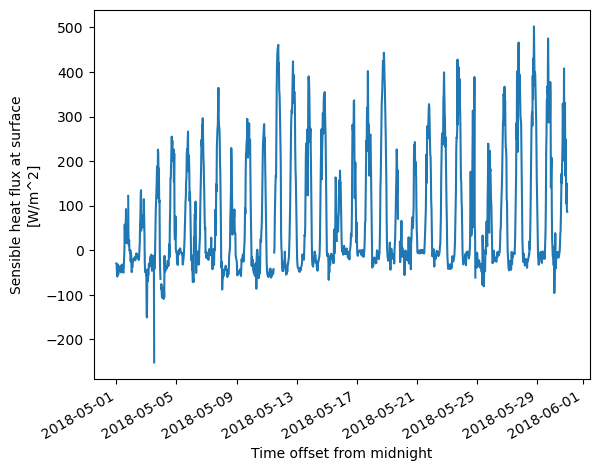

In [195]:
# We can use xarray funcationality to quickly plot up the data
ds['sensible_heat_flux'].plot()

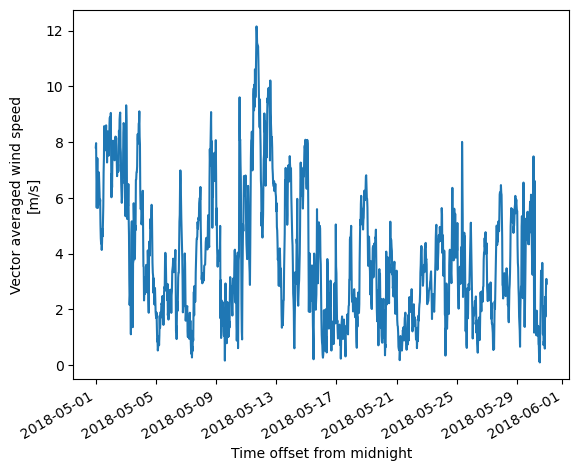

In [196]:
# Let's just make sure the wind data looks good as well
ds['wind_spd'].plot()

## Quality Control of ECOR Data

If you read through the ECOR instrument handbook, you may have noticed that at some sites, there is not sufficient fetch for the measurements and the data are suspect.  We need to be able to apply those limits to the data as well as filter the data based on the qc variables that are included in the file.  Additionally, ARM instrument experts (Mentors) routinely write data quality reports (DQR) on the data if there are problems.  This section will look at how to use all this information to QC the data.

In [197]:
# First, let's build a function that has the "Good" fetch directions defined
def get_arm_fetch(site, fac):
    """
    Each SGP ECOR site has specific directions where the fetch is good
    These ranges list are of good fetch directions
    """
    ranges=[]
    if site == 'sgp':
        if fac == 'E1':  #ECOR
            ranges = [[0, 53], [120, 360]]
        if fac == 'E2':  # EBBR
            ranges = [[71, 137], [223, 289]]
        if fac == 'E3':  #ECOR
            ranges = [[0, 48], [132, 260]]
        if fac == 'E4':  # EBBR
            ranges = [[0, 158], [202, 360]]
        if fac == 'E5':  #ECOR
            ranges = [[80, 154], [154, 260]]
        if fac == 'E6':  #ECOR
            ranges = [[0, 360]]
        if fac == 'E7':  # EBBR
            ranges = [[0, 244], [296, 360]]
        if fac == 'E8':  # EBBR
            ranges = [[0, 224], [314, 360]]
        if fac == 'E9':  # EBBR
            ranges = [[0, 360]]
        if fac == 'E10':  #ECOR
            ranges = [[0, 360]]
        if fac == 'E11':  # EBBR
            ranges = [[0, 360]]
        if fac == 'E12':  # EBBR
            ranges = [[0, 360]]
        if fac == 'E13':  # EBBR
            ranges = [[0, 52], [142, 194], [328, 360]]
        if fac == 'E14':  #ECOR
            ranges = [[129, 265], [352, 360], [0, 85]]
        if fac == 'E15':  # EBBR
            ranges = [[133, 360]]
        if fac == 'E16':  #ECOR
            ranges = [[134, 269], [334, 360]]
        if fac == 'E18':  # EBBR
            ranges = [[138, 325]]
        if fac == 'E19':  # EBBR
            ranges = [[0, 133], [151, 360]]
        if fac == 'E20':  # EBBR
            ranges = [[0, 230], [310, 360]]
        if fac == 'E21':  #ECOR
            ranges = [[30, 360]]
        if fac == 'E22':  # EBBR
            ranges = [[0, 49], [139, 360]]
        if fac == 'E24':  #ECOR
            ranges = [[80, 280]]
        if fac == 'E25':  # EBBR
            ranges = [[30, 360]]
        if fac == 'E26':  # EBBR
            ranges = [[0, 33], [243, 360]]
        if fac == 'E27':  # EBBR
            ranges = [[20,156]]
        if fac == 'E31':  #ECOR
            ranges = [[100, 200], [30, 80]]
        if fac == 'E32':  # EBBR
            ranges = [[0,360]]
        if fac == 'E33':  #ECOR
            ranges = [[100, 300], [40, 80]]
        if fac == 'E34':  # EBBR
            ranges = [[0,360]]
        if fac == 'E35':  # EBBR
            ranges = [[0,360]]
        if fac == 'E36':  # EBBR
            ranges = [[0,360]]
        if fac == 'E37':  #ECOR
            ranges = [[135, 260], [280, 310]]
        if fac == 'E38':  #ECOR
            ranges = [[150, 260]]
        if fac == 'E39':  #ECOR
            ranges = [[100, 260], [280, 360], [0, 80]]
        if fac == 'E40':  # EBBR
            ranges = [[0,360]]
        if fac == 'E41':  #ECOR
            ranges = [[100, 260], [280, 360], [0, 80]]

    return ranges

In [198]:
# Let's first apply DQRs (if any) to the data
# This will print out a link to the full DQR if there is one
ds = act.qc.arm.add_dqr_to_qc(ds, dqr_link=True)

# Next, we will filter the data based on the QC
# Let's only remove the "Bad" data for now
# The VAP may also automatically set the data to NAN when it fails QC
ds.qcfilter.datafilter(rm_assessments=['Bad'], del_qc_var=False)

# We could filter the data based on winds here, but it may be easier to
# do when we are getting the crop information for each wind direction

### Crop Type Information

ACT has a function to access crop type data from the [USDA Cropscape](https://nassgeodata.gmu.edu/CropScape) portal.  This is somewhat of an odd feature to have in ACT, but surface type information is very important to surface meteorological measurements.  Let's get the crop type for each wind sample and see if there are ways you can think of to make this more effecient for processing large datasets.

Don't forget that crop types may change by year!

In [199]:
# Set a dummy wind direction variable
c_dir = np.arange(0, 361, 45)
lat = ds['lat'].values
lon = ds['lon'].values
time = ds['time'].values

# We will need the year for getting the crop type
year = time.astype('datetime64[Y]').astype(int) + 1970
unique_year = np.unique(year)

# Create a dictionary to house all the crop information
crop_dict = {}
for yr in unique_year:
        crop = []
        for i, d in enumerate(c_dir):
            lat2, lon2 = act.utils.geo_utils.destination_azimuth_distance(lat[0], lon[0], d, 50.)
            crop.append(act.discovery.get_cropscape.croptype(lat2, lon2, yr))
        if crop[0] == None:
            crop[0] = crop[-1]
        crop_dict[yr] = {'c_dir': c_dir, 'crop_type': crop}

/opt/anaconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nassgeodata.gmu.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nassgeodata.gmu.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nassgeodata.gmu.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages

In [200]:
wdir = ds['wind_dir'].values
bins = list(c_dir + 22.5)
bins = np.asarray([0] + bins)
ds_year = ds.groupby('time.year')

# Get good fetch ranges for this site
site = ds.attrs['site_id']
fac = ds.attrs['facility_id']
ranges = get_arm_fetch(site, fac)
qc_ind = []
for r in ranges:
    qc_ind = np.concatenate((qc_ind, np.where((wdir >= r[0]) & (wdir <= r[1]))[0]))

# Set the QC variable for the wind direction.
qc_crop = np.zeros(len(wdir))
qc_crop[qc_ind.astype(int)] = 1

crop_type = np.empty(len(wdir), dtype=object)
for yr in ds_year.groups.keys():
    ds_wind = ds_year[yr].groupby_bins('wind_dir', bins, labels=bins.astype(str)[:-1], include_lowest=True)
    for i, b in enumerate(bins[:-1].astype(str)):
        ind = ds_wind.groups[b]
        crop_type[ind] = crop_dict[yr]['crop_type'][i]
        
# Add crop type and QC flag to existing object
atts = {'long_name': 'Crop type information based on wind direction as taken from CropScape',
            'units': 'unitless'}
da = xr.DataArray(data=crop_type, dims=ds['wind_dir'].dims, name='crop_type', attrs=atts)
ds['crop_type'] = da 
        
ds.qcfilter.create_qc_variable('crop_type',flag_type=True)
ds['qc_crop_type'].values = qc_crop
ds['qc_crop_type'].attrs['flag_values'] = [0,1]
ds['qc_crop_type'].attrs['flag_meanings'] = ['Sufficient Fetch','Insufficient Fetch']
ds['qc_crop_type'].attrs['flag_assessments'] = ['Good','Suspect']

### Putting it All Together

We have the ECOR data, we have the crop data, now let's look at the results!

{'plot_handle': <Axes: title={'center': 'sgp30qcecorE14.s1 sensible_heat_flux on 20180501'}, xlabel='(W/m^2)', ylabel='count'>,
 'bins': array([-252.07791 , -176.64098 , -101.20404 ,  -25.767105,   49.66983 ,
         125.106766,  200.5437  ,  275.98065 ,  351.41757 ,  426.8545  ,
         502.29144 ], dtype=float32),
 'histogram': array([  1,   6, 306, 579, 136, 106, 133,  89,  49,  12])}

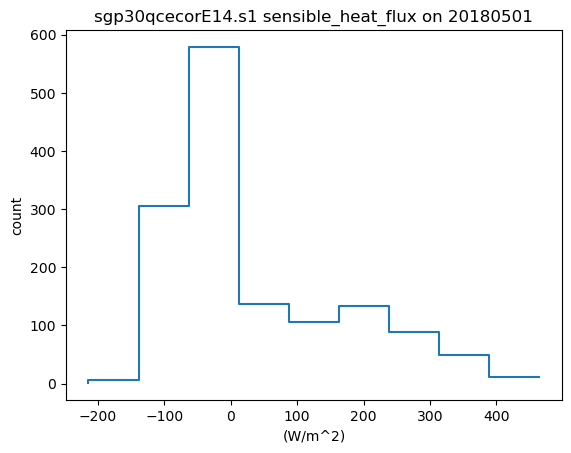

In [201]:
# First let's plot out all the data
hist = act.plotting.DistributionDisplay(ds)
hist.plot_stairstep_graph('sensible_heat_flux')

In [202]:
# Next let's look at the crop types we have for this site
ds['crop_type'].values

array(['Alfalfa', 'Alfalfa', 'Alfalfa', ..., 'Grass/Pasture',
       'Grass/Pasture', 'Grass/Pasture'], dtype=object)

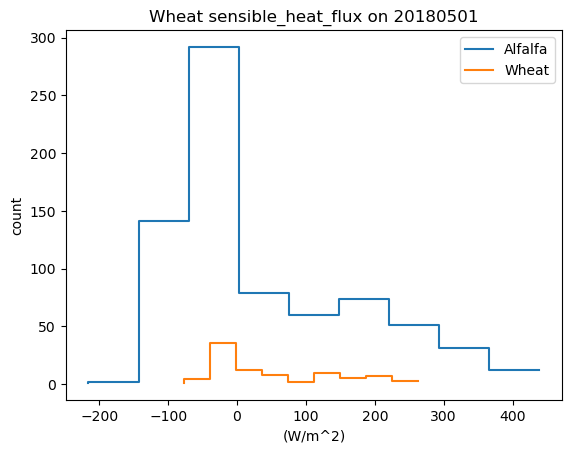

In [203]:
# Let's pick two of these to plot up
# Feel free to change the types around as well
ds_alfalfa = ds.where(ds.crop_type == 'Alfalfa')
ds_wheat = ds.where(ds.crop_type == 'Winter Wheat')

# Let's plot again
hist = act.plotting.DistributionDisplay({'Alfalfa': ds_alfalfa, 'Wheat': ds_wheat})
hist.plot_stairstep_graph('sensible_heat_flux', dsname='Alfalfa', label='Alfalfa')
hist.plot_stairstep_graph('sensible_heat_flux', dsname='Wheat', label='Wheat')
plt.legend()

/Users/atheisen/Code/ACT/act/plotting/windrosedisplay.py:424: RuntimeWarning: Mean of empty slice
  mean_data[i, j] = np.nanmean(data[idx])
/opt/anaconda3/lib/python3.10/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/Users/atheisen/Code/ACT/act/plotting/windrosedisplay.py:424: RuntimeWarning: Mean of empty slice
  mean_data[i, j] = np.nanmean(data[idx])


<PolarAxes: title={'center': 'Mean of sensible_heat_flux (W/m^2) by\n wind_dir from 20180501 to 20180530'}>

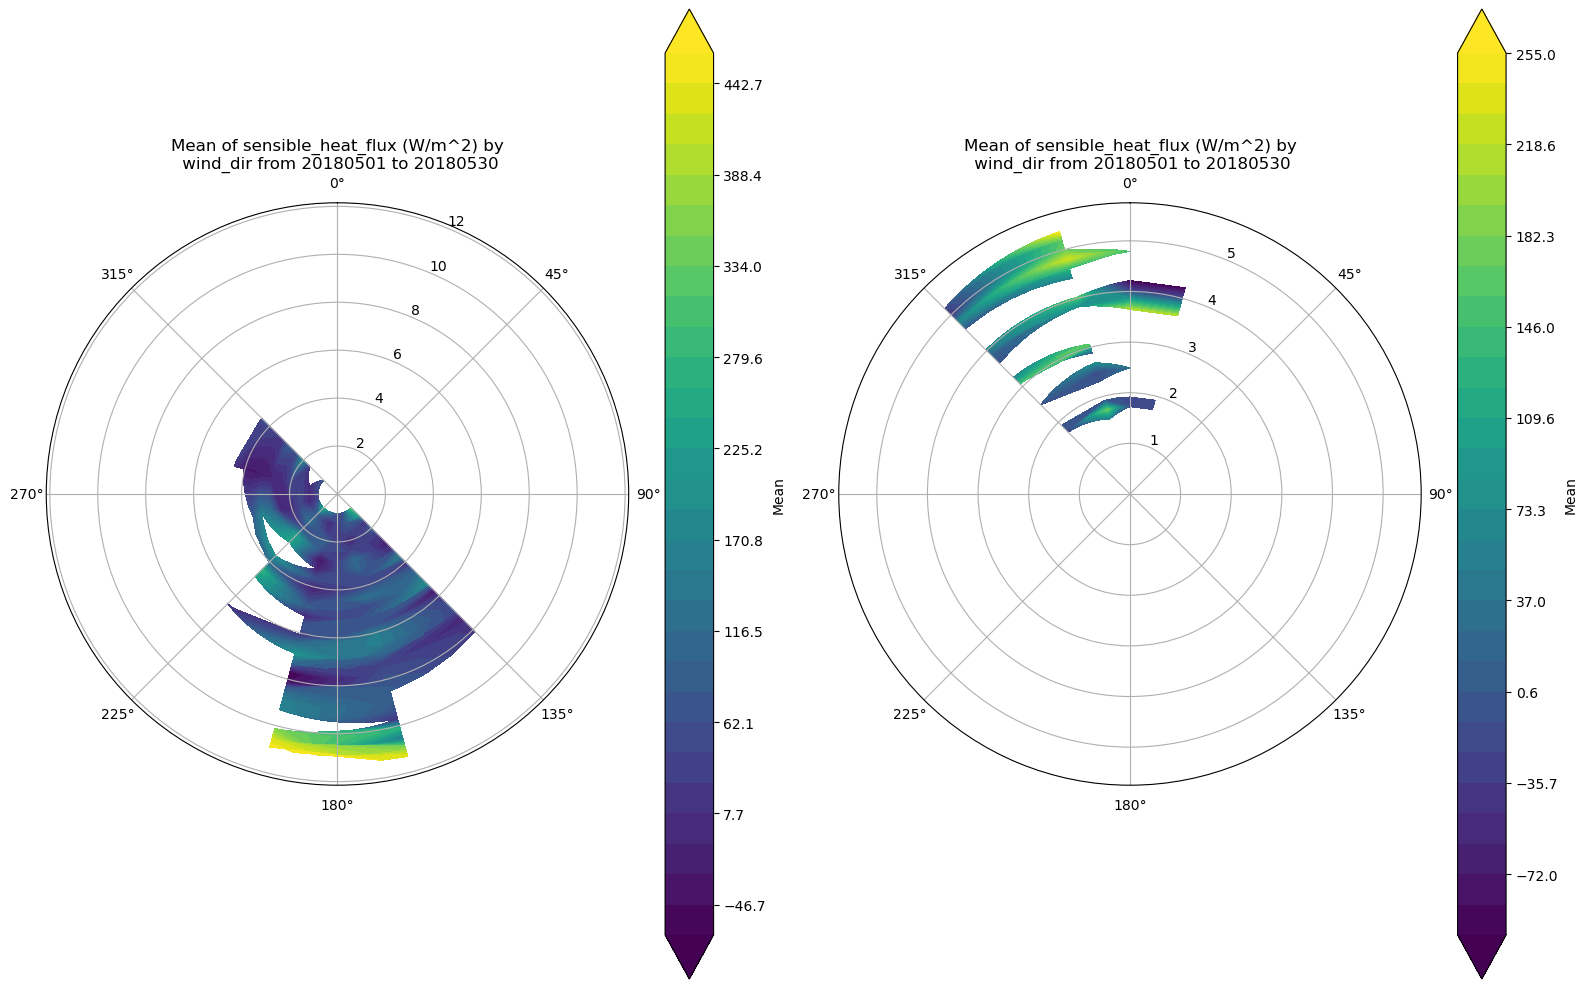

In [204]:
# Lets try a different type of display that will show at
# which wind direction and speeds we see larger fluxes
display = act.plotting.WindRoseDisplay({'Alfalfa': ds_alfalfa, 'Wheat': ds_wheat},
                                       subplot_shape=(1,2), figsize=(16,10))
display.plot_data('wind_dir', 'wind_spd', 'sensible_heat_flux', num_dirs=12, 
                  plot_type='contour', dsname='Alfalfa', subplot_index=(0,0), contour_type='mean')
display.plot_data('wind_dir', 'wind_spd', 'sensible_heat_flux', num_dirs=12, 
                  plot_type='contour', dsname='Wheat', subplot_index=(0,1), contour_type='mean')

### What do we see?

The above stairstep graph shows there are some differences in sensible heat flux between alfalfa and wheat during this period but it's hard to tell at which stage of their growing cycle each crop was.  Some more investigation might be warranted.  Site operations keeps logs of vegetation at each of the sites which could provide more detailed information.  

In the second set of plots, more data would definitely help fill in the contours and we might see some interesting features of the fluxes based on the direction and speed.

Any other observations?

---

## Next Steps

This was just a quick example for processing a weeks worth of data from one facility at ARM's SGP site.  There is much more data to get processing on!

1. Look at how you can improve the function to get the crop type based on wind direction.  It might be best to get the crop types by wind direction for every degree or 2 for a single year and use that instead of querying the API for each sample.
1. Process a year's worth of data and see what that looks like!
1. Develop some statistics that you can track for each crop type (min, max, median, mean are a good start) by year
1. Look at other variables like latent_heat_flux.  We can also look at the uncorrected CO2 Flux from the ECOR datastream or look at the new ECORSF data to see how it compares.
1. Now that this process is set, are there other systems or variables that would be interesting to look at?
1. Have fun!  This project is for you to get familiar with ARM, Fluxes, and explore data!

## Resources and references

### Datasets used in this example
Xie, S. Quality Controlled Eddy Correlation Flux Measurement (30QCECOR). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1097546

Sullivan, R., Billesbach, D., Keeler, E., & Ermold, B. Eddy Correlation Flux Measurement System (30ECOR). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1025039

### Cropscape Citations
Han, W., Yang, Z., Di, L., Yue, P., 2014. A geospatial Web service approach for creating on-demand Cropland Data Layer thematic maps. Transactions of the ASABE, 57(1), 239-247.

Han, W., Yang, Z., Di, L., Yagci, A., Han, S., 2014. Making Cropland Data Layer data accessible and actionable in GIS education. Journal of Geography, 113(3), 129-138.

Han, W., Yang, Z., Di, L., Mueller, R., 2012. CropScape: A Web service based application for exploring and disseminating US conterminous geospatial cropland data products for decision support. Computers and Electronics in Agriculture, 84, 111–123.

Boryan, C., Yang, Z., Willis, P., 2014. US geospatial crop frequency data layers. Third International Conference on Agro-geoinformatics (Agro-geoinformatics 2014), August 11-14, 2014, Beijing, China.

Boryan, C., Yang, Z., Mueller, R., Craig, M., 2011. Monitoring US agriculture: the US Department of Agriculture, National Agricultural Statistics Service, Cropland Data Layer Program. Geocarto International, 26(5), 341–358. 

### ARM Instrument Handbook
Cook, D. R. (2018). Eddy correlation flux measurement system (ECOR) instrument handbook (No. DOE/SC-ARM-TR-052). DOE Office of Science Atmospheric Radiation Measurement (ARM) Program (United States).

Tang, S., Xie, S., Zhang, Y., & Cook, D. R. (2019). The QCECOR Value-Added Product: Quality-Controlled Eddy Correlation Flux Measurements (No. DOE/SC-ARM-TR-223). DOE Office of Science Atmospheric Radiation Measurement (ARM) Program (United States).

### Author
Adam Theisen and Ryan Sullivan

Corresponding Email: atheisen@anl.gov